# Running the multiVelocity pipeline one single sample

## Setting up the environment

In [2]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import multivelo as mv
import matplotlib.pyplot as plt
import sys
import seaborn as sns

In [3]:
# Determine the folder in which the code is executed
WORKING_DIR = os.getcwd()
sys.path.append(os.path.abspath( WORKING_DIR))

# Run the params codes
%run -i ../../globalParams.py #GlobalParams
%run -i ../../sampleParams.py #sampleParams
%run -i ./analysisParams.py #AnalysisParams

In [4]:
# scvelo and panda parameters

scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

## Reading in unspilced and spliced counts

In [4]:
# Read the adata object
#adata = sc.read_h5ad("/mnt/DOSI/EVLAB/BIOINFO/BIOINFO_PROJECT/Lung_Basel/01_ALL_SAMPLES/05_Output/04_SCENICplus_Analysis/04b_Step2_Anndata_Prepro_scRNAseq/adata.h5ad") #Need to improve this
adata = sc.read_h5ad( os.path.join( PATH_EXPERIMENT_OUTPUT , ANALYSIS_04b_STEP_NAME , "adata.h5ad"))

## Update adata name
# Create a mapping dictionary called old_to_new_mapping from the old categories to the new categories => This is directly done in analysis params.

# Replace the old categories with the new ones
adata.obs[CELL_TYPE_COLNAME] = adata.obs[CELL_TYPE_COLNAME].map(old_to_new_mapping)
# Update the categories to reflect the new set
adata.obs[CELL_TYPE_COLNAME] = adata.obs[CELL_TYPE_COLNAME].astype('category')


###################
#Simplify the following code in a loop
# load dimensional reductions:
#RNA = pd.read_csv("/mnt/DOSI/EVLAB/BIOINFO/BIOINFO_PROJECT/Lung_Basel/01_ALL_SAMPLES/05_Output/04_SCENICplus_Analysis/04a0_Step0_R_Extract_Metadata/Embeddings/RNA_UMAP_TABLE.csv")
RNA = pd.read_csv(os.path.join( PATH_EXPERIMENT_OUTPUT , ANALYSIS_04a0_STEP_NAME, "Embeddings/RNA_UMAP_TABLE.csv"), index_col = 0)
RNA.index = [f"{cell.split('_')[1]}_{cell.split('_')[0]}" for cell in RNA.index]
RNA = RNA.reindex(adata.obs.index)

ATAC = pd.read_csv(os.path.join( PATH_EXPERIMENT_OUTPUT , ANALYSIS_04a0_STEP_NAME, "Embeddings/ATAC_UMAP_TABLE.csv"), index_col = 0)
ATAC.index = [f"{cell.split('_')[1]}_{cell.split('_')[0]}" for cell in ATAC.index]
ATAC = ATAC.reindex(adata.obs.index)

WNN = pd.read_csv(os.path.join( PATH_EXPERIMENT_OUTPUT , ANALYSIS_04a0_STEP_NAME, "Embeddings/WNN_UMAP_TABLE.csv"), index_col = 0)
WNN.index = [f"{cell.split('_')[1]}_{cell.split('_')[0]}" for cell in WNN.index]
WNN = WNN.reindex(adata.obs.index)


# set them
adata.obsm['X_rna_umap'] = RNA.to_numpy()
adata.obsm['X_atac_umap'] = ATAC.to_numpy()
adata.obsm['X_wnn_umap'] = WNN.to_numpy()
###############################

#Set the seed
np.random.seed(1234)

In [5]:
#Load the Loom object
# Specify the folder containing the .loom file
folder_path = os.path.join(PATH_TO_VELOCITY_FOLDER ,SAMPLE_OF_INTEREST)

# Find the .loom file in the folder
loom_files = [f for f in os.listdir(folder_path) if f.endswith('.loom')]

# Check if there is exactly one .loom file and read it
if len(loom_files) == 1:
    loom_file_path = os.path.join(folder_path, loom_files[0])
    adata_rna = scv.read(loom_file_path, cache=True)
    print(f"Loaded {loom_files[0]}")
else:
    print("Error: There should be exactly one .loom file in the folder.")

# Modify the observation names
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1_' + x.split(':')[0] for x in adata_rna.obs_names]
# Ensure variable names are unique
adata_rna.var_names_make_unique()

Loaded CSS4_BS824.loom


### Have a quick look at where to put the threshold for total count per cell

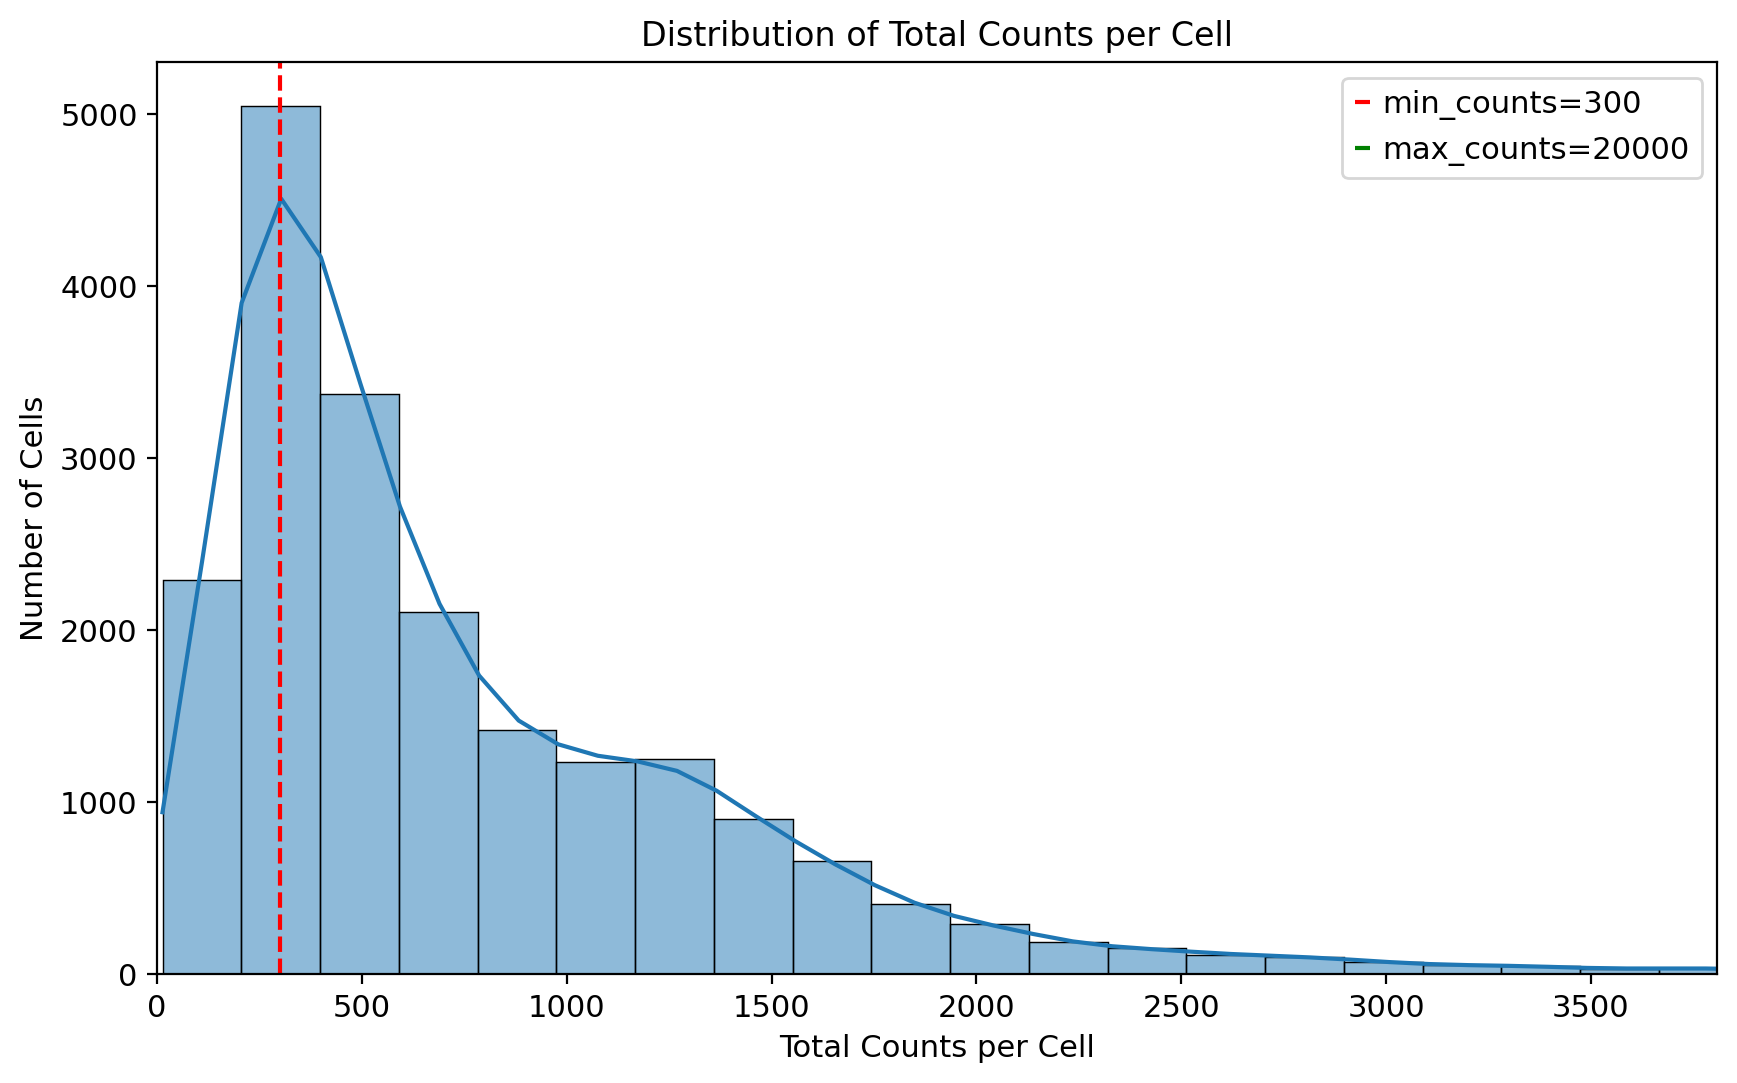

In [6]:
# Calculate total counts per cell
total_counts = adata_rna.obs['n_counts'] if 'n_counts' in adata_rna.obs else adata_rna.X.sum(axis=1).A1

# Calculate the 99th percentile to limit the x-axis
x_limit = np.percentile(total_counts, 99)

# Plot a histogram of total counts with more bins
plt.figure(figsize=(10, 6))
sns.histplot(total_counts, bins=100, kde=True)  # Increased bins for more granularity
plt.xlabel('Total Counts per Cell')
plt.ylabel('Number of Cells')
plt.title('Distribution of Total Counts per Cell')
plt.axvline(x=ADATA_RNA_MIN, color='red', linestyle='--', label=f"min_counts={ADATA_RNA_MIN}")
plt.axvline(x=ADATA_RNA_MAX, color='green', linestyle='--', label=f"max_counts={ADATA_RNA_MAX}")
plt.xlim(0, x_limit)  # Limit the x-axis to the 99th percentile
plt.legend()
plt.show()


### Apply the  filter on cells

In [7]:
#Apply the filter on cells
sc.pp.filter_cells(adata_rna, min_counts=ADATA_RNA_MIN)
sc.pp.filter_cells(adata_rna, max_counts=ADATA_RNA_MAX)

### Keep only the top 1000 genes

In [8]:
# Top 1000 variable genes are used for downstream analyses.
scv.pp.filter_and_normalize(adata_rna, min_shared_counts=10, n_top_genes=1000)

Filtered out 28263 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.


/opt/conda/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1642: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

Extracted 1000 highly variable genes.
Logarithmized X.


/opt/conda/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


### Compare filtered loom object with the total object

In [9]:
# Find the intersection of observation names
common_obs_names = set(adata.obs_names).intersection(adata_rna.obs_names)

# Convert to a list if needed
common_obs_names = list(common_obs_names)

# Output the number of common observation names
print(f"Number of common observation names: {len(common_obs_names)}")

# Optionally, display the common observation names
#print(common_obs_names)

# Filter adata.obs for rows where the sample is "sample of interest and get the row names
sample_cells = adata.obs_names[adata.obs['sample'] == SAMPLE_OF_INTEREST]

# Convert to a list if needed
sample_cells = list(sample_cells)

# Output the row names
print(f"Number of cells in the same patient in adata object: {len(sample_cells)}")


Number of common observation names: 4972
Number of cells in the same patient in adata object: 5634


### Keep only the data that are present in the final object and insert the metadata in adata_rna

In [10]:
# Step 1: Subset adata_rna to only include common observation names
adata_rna = adata_rna[adata_rna.obs_names.isin(common_obs_names)].copy()

# Step 2: Create adata.obs2 containing only common observation names from adata.obs
adata_obs2 = adata.obs.loc[adata.obs_names.isin(common_obs_names)].copy()

# Step 3: Reorder adata_obs2 to match the order in adata_rna
adata_obs2 = adata_obs2.reindex(adata_rna.obs_names)

# Step 4: Add the information from adata_obs2 to adata_rna.obs
adata_rna.obs = pd.concat([adata_rna.obs, adata_obs2], axis=1)

/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


### Focus on pops of interest for trajectories

In [11]:
adata_rna = adata_rna[adata_rna.obs[CELL_TYPE_COLNAME].isin(populations_of_interest)]

/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


## Preprocessing the ATAC counts

In [12]:
#Load the atac object
# Specify the folder containing the .loom file
folder_path = os.path.join(
    PATH_TO_VELOCITY_FOLDER,
    SAMPLE_OF_INTEREST,
    f"{SAMPLE_OF_INTEREST}_filtered_feature_bc_matrix"
)

adata_atac = sc.read_10x_mtx(folder_path, var_names='gene_symbols', cache=True, gex_only=False)
adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]

In [13]:
adata_atac

View of AnnData object with n_obs × n_vars = 20000 × 119861
    var: 'gene_ids', 'feature_types'

In [14]:
from comm import create_comm

In [15]:
# We aggregate peaks around each gene as well as those that have high correlations with promoter peak or gene expression.
# Peak annotation contains the metadata for all peaks.
# Feature linkage contains pairs of correlated genomic features.
adata_atac = mv.aggregate_peaks_10x(adata_atac,
                                    os.path.join(   PATH_TO_VELOCITY_FOLDER,    SAMPLE_OF_INTEREST,   f"{SAMPLE_OF_INTEREST}_atac_peak_annotation.tsv"),
                                    os.path.join(   PATH_TO_VELOCITY_FOLDER,    SAMPLE_OF_INTEREST,   f"{SAMPLE_OF_INTEREST}_feature_linkage.bedpe")
)
                        

CellRanger ARC identified as 2.0.0

Found 19094 genes with promoter peaks



/home/rebuffet/.local/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/19094 [00:00<?, ?it/s]

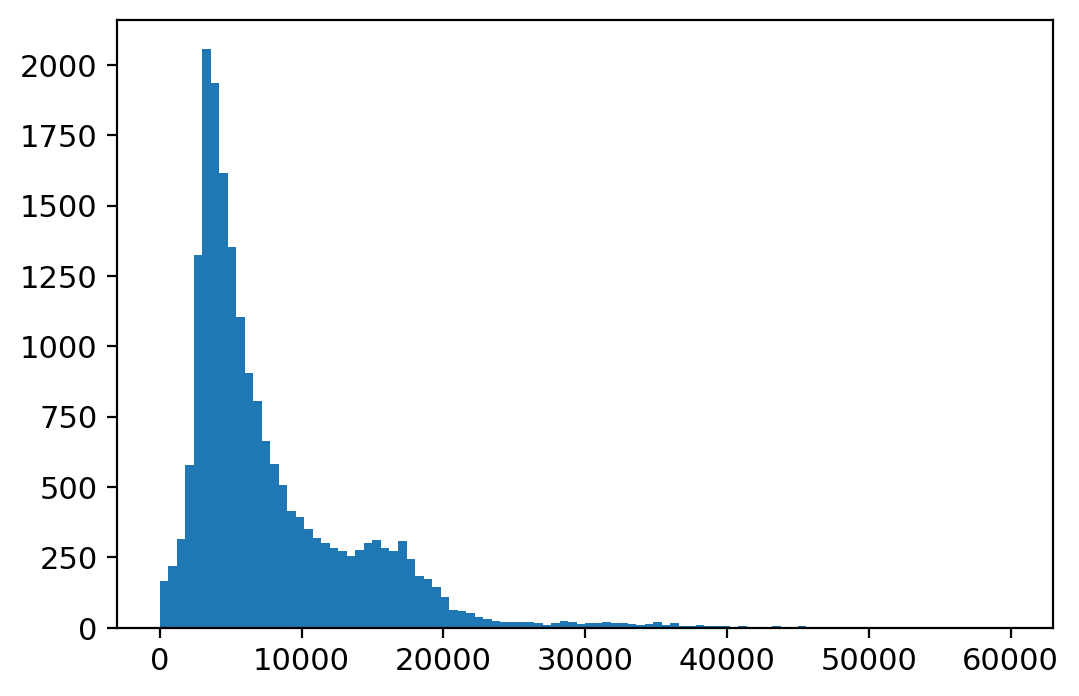

In [16]:
# Let's examine the total count distribution and remove outliers.
plt.hist(adata_atac.X.sum(1), bins=100, range=(0, ADATA_ATAC_MAX));

In [17]:
sc.pp.filter_cells(adata_atac, min_counts= ADATA_ATAC_MIN)
sc.pp.filter_cells(adata_atac, max_counts= ADATA_ATAC_MAX)

In [18]:
# We normalize aggregated peaks with TF-IDF.
mv.tfidf_norm(adata_atac)

## Finding shared barcodes and features between RNA and ATAC

In [19]:
# Update obs_names by adding "_SAMPLE_OF_INTEREST" at the end of each barcode
adata_atac.obs_names = [f"{barcode}_{SAMPLE_OF_INTEREST}" for barcode in adata_atac.obs_names]

# Verify the changes
#print(adata_atac.obs_names[:5])  # Display the first few updated names for confirmation


In [20]:
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
len(shared_cells), len(shared_genes)

(2179, 896)

## Reload the data in and carry on with a subset of cells

In [21]:
# Reloading the adata_rna and adding its info
#Load the Loom object
# Specify the folder containing the .loom file
folder_path = os.path.join(PATH_TO_VELOCITY_FOLDER ,SAMPLE_OF_INTEREST)

# Find the .loom file in the folder
loom_files = [f for f in os.listdir(folder_path) if f.endswith('.loom')]

# Check if there is exactly one .loom file and read it
if len(loom_files) == 1:
    loom_file_path = os.path.join(folder_path, loom_files[0])
    adata_rna = scv.read(loom_file_path, cache=True)
    print(f"Loaded {loom_files[0]}")
else:
    print("Error: There should be exactly one .loom file in the folder.")

# Modify the observation names
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1_' + x.split(':')[0] for x in adata_rna.obs_names]
# Ensure variable names are unique
adata_rna.var_names_make_unique()

## Adding the metadata in
# Find the intersection of observation names
common_obs_names = set(adata.obs_names).intersection(adata_rna.obs_names)

# Convert to a list if needed
common_obs_names = list(common_obs_names)

# Output the number of common observation names
print(f"Number of common observation names: {len(common_obs_names)}")

# Optionally, display the common observation names
#print(common_obs_names)

# Filter adata.obs for rows where the sample is "sample of interest and get the row names
sample_cells = adata.obs_names[adata.obs['sample'] == SAMPLE_OF_INTEREST]

# Convert to a list if needed
sample_cells = list(sample_cells)

# Output the row names
print(f"Number of cells in the same patient in adata object: {len(sample_cells)}")

# Step 1: Subset adata_rna to only include common observation names
adata_rna = adata_rna[adata_rna.obs_names.isin(common_obs_names)].copy()

# Step 2: Create adata.obs2 containing only common observation names from adata.obs
adata_obs2 = adata.obs.loc[adata.obs_names.isin(common_obs_names)].copy()

# Step 3: Reorder adata_obs2 to match the order in adata_rna
adata_obs2 = adata_obs2.reindex(adata_rna.obs_names)

# Step 4: Add the information from adata_obs2 to adata_rna.obs
adata_rna.obs = pd.concat([adata_rna.obs, adata_obs2], axis=1)

Loaded CSS4_BS824.loom
Number of common observation names: 5634
Number of cells in the same patient in adata object: 5634


/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [22]:
#Subsetting the two objects to keep only the cells and genes of interest
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]

In [23]:
#Running standard procedure
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

Normalized count data: X, spliced, unspliced.
computing neighbors


/tmp/ipykernel_104425/1157875168.py:3: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_rna)


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [24]:
#Make sure that data annotation is categorial
adata_rna.obs[CELL_TYPE_COLNAME] = adata_rna.obs[CELL_TYPE_COLNAME].astype('category')

/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


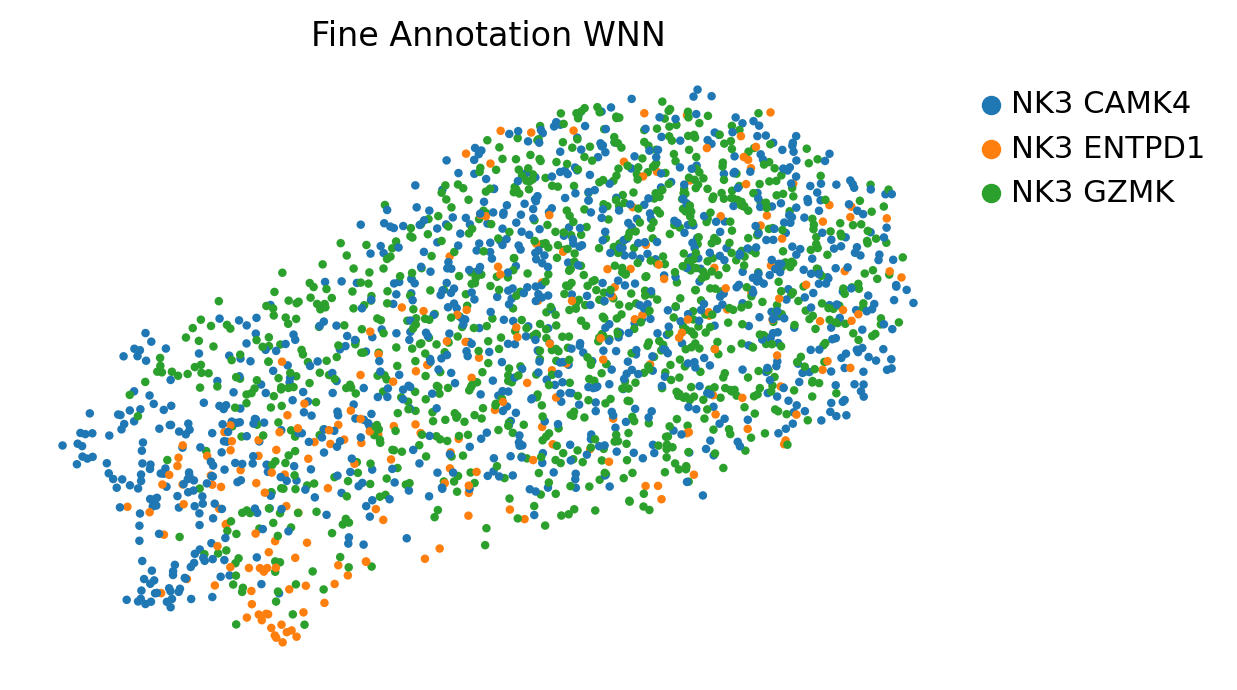

In [25]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color= CELL_TYPE_COLNAME)

/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


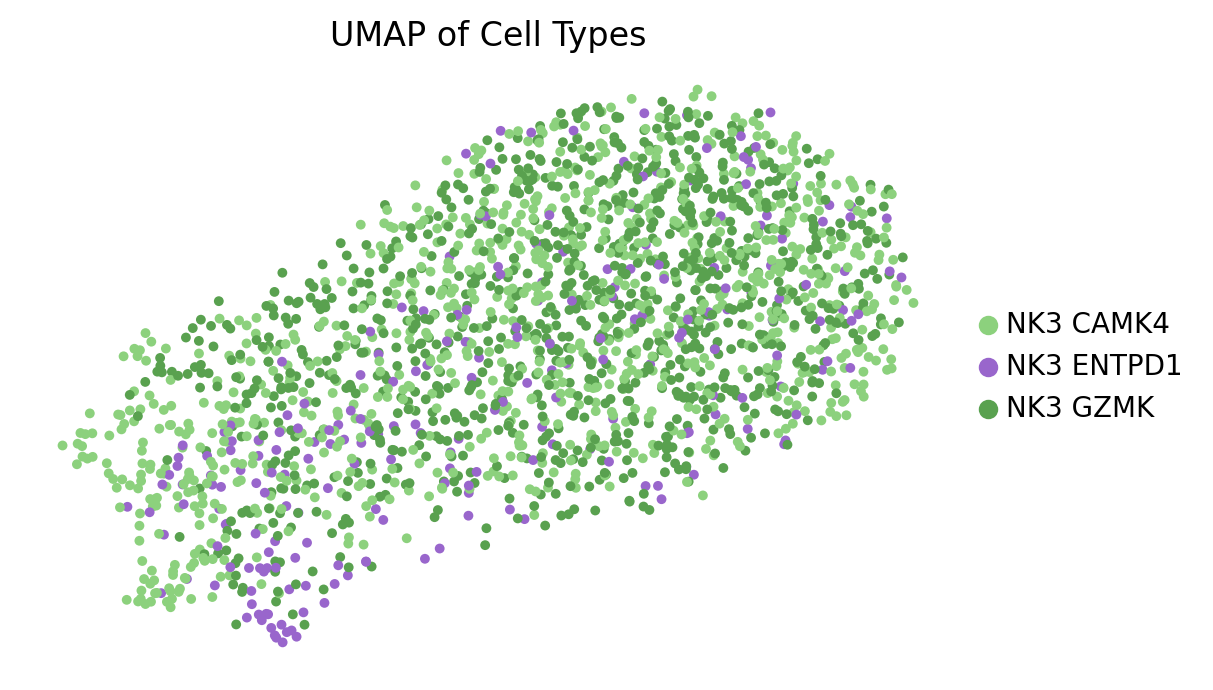

In [26]:
import scvelo as scv

# Ensure that the color map is defined for the specific clusters
cluster_color_map = dict(zip(cluster_names, color_codes))

# Optionally, add titles and labels for better visualization
scv.pl.umap(
    adata_rna, 
    color=CELL_TYPE_COLNAME, 
    palette=cluster_color_map, 
    size=50, 
    legend_loc='right', 
    legend_fontsize=10,
    title='UMAP of Cell Types', 
    xlabel='UMAP 1', 
    ylabel='UMAP 2', 
    frameon=False
)


In [27]:
#Inject WNN UMAP dimensions in the object
WNN = pd.read_csv(os.path.join( PATH_EXPERIMENT_OUTPUT , ANALYSIS_04a0_STEP_NAME, "Embeddings/WNN_UMAP_TABLE.csv"), index_col = 0)
# Modify the row names to the desired format
WNN.index = [f"{cell.split('_')[1]}_{cell.split('_')[0]}" for cell in WNN.index]
WNN = WNN.reindex(adata_rna.obs.index)

#Inject into the object
# set them in the umap slot
adata_rna.obsm['X_umap'] = WNN.to_numpy()

/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


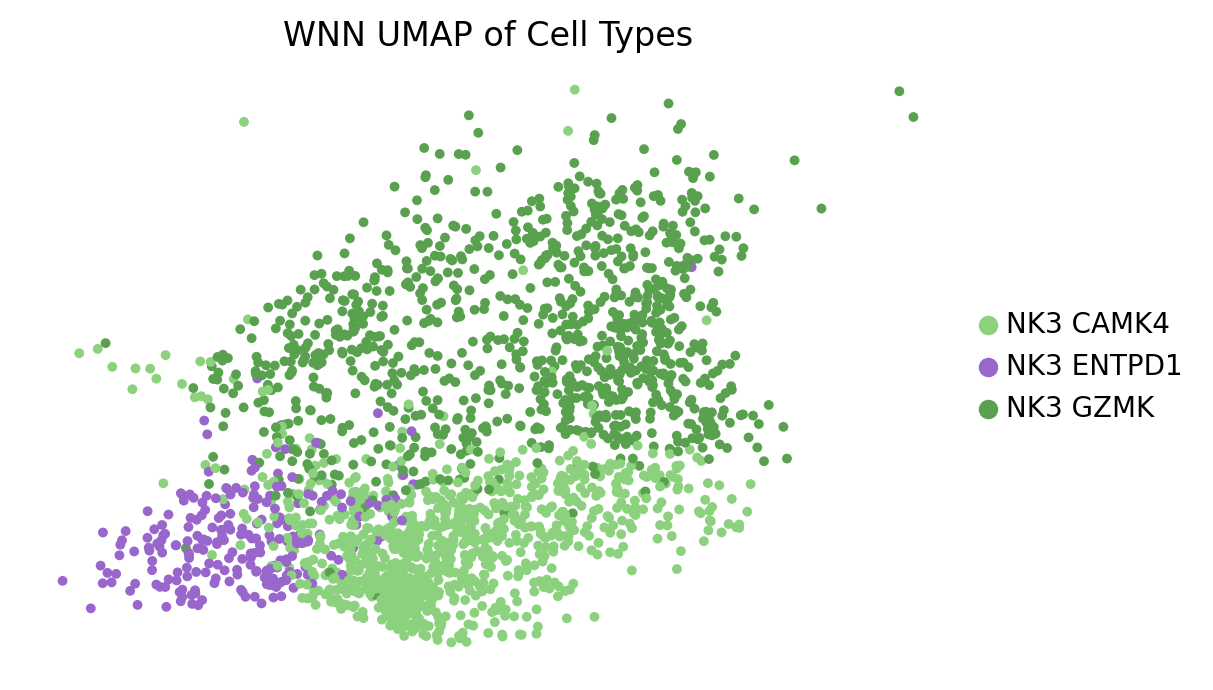

In [28]:
# Plot the UMAP using the 'X_wnn_umap' embedding
# Optionally, add titles and labels for better visualization
scv.pl.umap(
    adata_rna, 
    color=CELL_TYPE_COLNAME, 
    palette=cluster_color_map, 
    size=50, 
    legend_loc='right', 
    legend_fontsize=10,
    title='WNN UMAP of Cell Types', 
    xlabel='UMAP 1', 
    ylabel='UMAP 2', 
    frameon=False
)


## Saving the filtered cells

In [30]:
# Write out filtered cells and prepare to run Seurat WNN --> R script can be found on Github.
# Construct the file path
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Out_01a_Filteredcells_per_indiv_sample", "filtered_cells",
    f"{SAMPLE_OF_INTEREST}_filtered_cells.txt"
)

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the obs_names to the specified file path
adata_rna.obs_names.to_frame().to_csv(file_path, header=False, index=False)

# Print the file path to confirm where the file was saved
print(f"Filtered cells saved to: {file_path}")


Filtered cells saved to: /mnt/DOSI/EVLAB/BIOINFO/BIOINFO_PROJECT/Lung_Basel/01_ALL_SAMPLES/05_Output/07_MultiVelocity_NK3/05a_patient_by_patient/Out_01a_Filteredcells_per_indiv_sample/filtered_cells/CSS4_filtered_cells.txt


In [ ]:
#save the adata_rna and adata_atac objects
# Construct the file path
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Out_01a_Filteredcells_per_indiv_sample", "adata_rna",
    f"{SAMPLE_OF_INTEREST}_adata_rna.h5ad"
)

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)


# Save the obs_names to the specified file path
adata_rna.write(file_path)

#save the adata_rna and adata_atac objects
# Construct the file path
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Out_01a_Filteredcells_per_indiv_sample", "adata_atac",
    f"{SAMPLE_OF_INTEREST}_adata_atac.h5ad"
)

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the obs_names to the specified file path
adata_atac.write(file_path)

## Smoothing gene aggregated peaks by neighbors

In [5]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt(os.path.join( PATH_TO_THE_Out_01b_Neighborhood_Graph_Per_Indiv, SAMPLE_OF_INTEREST,"nn_idx.txt"), delimiter=',')
nn_dist = np.loadtxt(os.path.join(PATH_TO_THE_Out_01b_Neighborhood_Graph_Per_Indiv, SAMPLE_OF_INTEREST,"nn_dist.txt"), delimiter=',')
nn_cells = pd.Index(pd.read_csv(os.path.join( PATH_TO_THE_Out_01b_Neighborhood_Graph_Per_Indiv, SAMPLE_OF_INTEREST,"nn_cells.txt"), header=None)[0])

# Make sure cell names match.
np.all(nn_cells == adata_atac.obs_names)

NameError: name 'adata_atac' is not defined

In [ ]:
mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)

## Running multi-omic dynamical model

In [ ]:
#This will take a while. Parallelization is high recommended.
mv.settings.VERBOSITY = 0

adata_result = mv.recover_dynamics_chrom(adata_rna,
                                         adata_atac,
                                         max_iter=5,
                                         init_mode="invert",
                                         parallel=True,
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         n_anchors=500,
                                         extra_color_key=CELL_TYPE_COLNAME)

In [ ]:
# Save the result for use later on
# Construct the file path
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT,"Out_01c_MultiVeloAnalysis" ,"multi_velo_results",
    f"{SAMPLE_OF_INTEREST}_multivelo_result.h5ad"
)

# Save the AnnData object to the specified file path
adata_result.write(file_path)

# Print the file path to confirm the save location
print(f"Result saved to: {file_path}")

In [ ]:
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Quality_metrics_Plots", 
    f"{SAMPLE_OF_INTEREST}_Plot1.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

mv.pie_summary(adata_result)

# Generate the pie summary plot
mv.pie_summary(adata_result)

# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')

# Close the figure to free memory
plt.close()

In [ ]:
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Quality_metrics_Plots", 
    f"{SAMPLE_OF_INTEREST}_Plot2.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)


# Generate the switch time summary plot
mv.switch_time_summary(adata_result)
plt.xticks(rotation=45)  # Rotate the labels by 45 degrees (adjust the angle as needed)

# Rotate the x-axis labels
mv.switch_time_summary(adata_result)
plt.xticks(rotation=45)  # Rotate the labels by 45 degrees (adjust the angle as needed)
# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')

# Close the figure to free memory
plt.close()

In [ ]:
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Quality_metrics_Plots", 
    f"{SAMPLE_OF_INTEREST}_Plot3.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

mv.likelihood_plot(adata_result)

# Generate the pie summary plot
mv.likelihood_plot(adata_result)

# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')

# Close the figure to free memory
plt.close()


## Computing velocity stream and latent time

In [ ]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

In [ ]:
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Velocity_streams_per_individuals", 
    f"{SAMPLE_OF_INTEREST}_Velostream.svg"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Generate and save the velocity embedding stream plot
mv.velocity_embedding_stream(adata_result, basis='umap', color=CELL_TYPE_COLNAME, save=file_path)

# Confirm the plot has been saved
print(f"Velocity stream plot saved to: {file_path}")

In [ ]:
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Velocity_streams_per_pseudotime", 
    f"{SAMPLE_OF_INTEREST}_Velostream_pseudotime.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80, save=file_path)

# Confirm the plot has been saved
print(f"Velocity stream by pseudotime plot saved to: {file_path}")

# Examine some example genes

In [ ]:
# Find the intersection of GENE_LIST_OF_INTEREST and adata_result.var_names
gene_list = list(set(GENE_LIST_OF_INTEREST).intersection(adata_result.var_names))

## Plot accessibility and expression against gene time

### Heavy code version

In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Accessibility_Expression_Against_Gene_Time", 
    f"{SAMPLE_OF_INTEREST}_Accessibility_Expression_Against_Gene_Time.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

mv.dynamic_plot(adata_result, gene_list, color_by='state', axis_on=False, frame_on=False)

# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')

# Close the figure to free memory
plt.close()


In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Velocity_Against_Gene_Time", 
    f"{SAMPLE_OF_INTEREST}_Velocity_Against_Gene_Time.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
mv.dynamic_plot(adata_result, gene_list, color_by='state', by='velocity', axis_on=False, frame_on=False)
# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')

# Close the figure to free memory
plt.close()


In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Accessibility_Expression_Against_Shared_Latent_Time", 
    f"{SAMPLE_OF_INTEREST}_Accessibility_Expression_Against_Shared_Latent_Time.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
mv.dynamic_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, gene_time=False, axis_on=False, frame_on=False)
# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')

# Close the figure to free memory
plt.close()


In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/unspliced_unspliced", 
    f"{SAMPLE_OF_INTEREST}_unspliced_unspliced.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, by='us', axis_on=False, frame_on=False)

# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()


In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Unspliced_spliced", 
    f"{SAMPLE_OF_INTEREST}_Unspliced_spliced.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by='c', by='us', cmap='coolwarm', title_more_info=True, axis_on=False, frame_on=False)

# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()

In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Chromatin_unspliced", 
    f"{SAMPLE_OF_INTEREST}_Chromatin_unspliced.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, by='cu', axis_on=False, frame_on=False)

# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()

In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/3Dphaseportraits", 
    f"{SAMPLE_OF_INTEREST}_3Dphaseportraits.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, by='cus', axis_on=False, downsample=2)
# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()

In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Arrow1", 
    f"{SAMPLE_OF_INTEREST}_Arrow1.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, by='us', axis_on=False, frame_on=False, downsample=2, velocity_arrows=True)
# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()

In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Arrow2", 
    f"{SAMPLE_OF_INTEREST}_Arrow2.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, by='cu', axis_on=False, frame_on=False, downsample=2, velocity_arrows=True)
# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()

In [ ]:
# Accessibility/expression by gene time, colored by the four potential states.
# The solid black curve indicates anchors.
# Construct the file path for saving the plot
file_path = os.path.join(
    PATH_ANALYSIS_OUTPUT, 
    "Figures/Downstream_Genes_Analysis/Arrow3", 
    f"{SAMPLE_OF_INTEREST}_Arrow3.pdf"
)

# Create the directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# Unspliced-spliced phase portraits, colored by celltype.
mv.scatter_plot(adata_result, gene_list, color_by=CELL_TYPE_COLNAME, by='cus', downsample=3, velocity_arrows=True)# Save the current figure to the specified file path
plt.savefig(file_path, format='pdf')
# Close the figure to free memory
plt.close()

### Sparse code Version

In [ ]:
import os
import matplotlib.pyplot as plt

def generate_plots(adata_result, gene_list, PATH_ANALYSIS_OUTPUT, SAMPLE_OF_INTEREST, CELL_TYPE_COLNAME):
    # Define all plot configurations
    plot_configs = [
        {
            "dir_name": "Accessibility_Expression_Against_Gene_Time",
            "plot_type": "dynamic",
            "params": {
                "color_by": "state",
                "axis_on": False,
                "frame_on": False
            }
        },
        {
            "dir_name": "Velocity_Against_Gene_Time",
            "plot_type": "dynamic",
            "params": {
                "color_by": "state",
                "by": "velocity",
                "axis_on": False,
                "frame_on": False
            }
        },
        {
            "dir_name": "Accessibility_Expression_Against_Shared_Latent_Time",
            "plot_type": "dynamic",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "gene_time": False,
                "axis_on": False,
                "frame_on": False
            }
        },
        {
            "dir_name": "unspliced_unspliced",
            "plot_type": "scatter",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "by": "us",
                "axis_on": False,
                "frame_on": False
            }
        },
        {
            "dir_name": "Unspliced_spliced",
            "plot_type": "scatter",
            "params": {
                "color_by": "c",
                "by": "us",
                "cmap": "coolwarm",
                "title_more_info": True,
                "axis_on": False,
                "frame_on": False
            }
        },
        {
            "dir_name": "Chromatin_unspliced",
            "plot_type": "scatter",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "by": "cu",
                "axis_on": False,
                "frame_on": False
            }
        },
        {
            "dir_name": "3Dphaseportraits",
            "plot_type": "scatter",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "by": "cus",
                "axis_on": False,
                "downsample": 2
            }
        },
        {
            "dir_name": "Arrow1",
            "plot_type": "scatter",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "by": "us",
                "axis_on": False,
                "frame_on": False,
                "downsample": 2,
                "velocity_arrows": True
            }
        },
        {
            "dir_name": "Arrow2",
            "plot_type": "scatter",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "by": "cu",
                "axis_on": False,
                "frame_on": False,
                "downsample": 2,
                "velocity_arrows": True
            }
        },
        {
            "dir_name": "Arrow3",
            "plot_type": "scatter",
            "params": {
                "color_by": CELL_TYPE_COLNAME,
                "by": "cus",
                "downsample": 3,
                "velocity_arrows": True
            }
        }
    ]

    # Generate each plot
    for config in plot_configs:
        # Construct file path
        file_path = os.path.join(
            PATH_ANALYSIS_OUTPUT,
            "Figures/Downstream_Genes_Analysis",
            config["dir_name"],
            f"{SAMPLE_OF_INTEREST}_{config['dir_name']}.pdf"
        )

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Generate plot based on type
        if config["plot_type"] == "dynamic":
            mv.dynamic_plot(adata_result, gene_list, **config["params"])
        else:  # scatter plot
            mv.scatter_plot(adata_result, gene_list, **config["params"])

        # Save and close figure
        plt.savefig(file_path, format='pdf')
        plt.close()

In [ ]:
generate_plots(
    adata_result,
    gene_list,
    PATH_ANALYSIS_OUTPUT,
    SAMPLE_OF_INTEREST,
    CELL_TYPE_COLNAME
)